In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

/tmp/ipykernel_153053/1408937334.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
SEED = 123 # since Danya doesnt provide his seed in notebooks anymore let me do it myself

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [3]:
data = pd.read_csv("../data/train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

In [5]:
data.describe()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
count,17568.000000,17996.000000,17996.000000,15982.000000,17996.000000,17996.000000,17996.000000,17996.000000,13619.000000,17996.000000,17996.000000,17996.000000,1.799600e+04,17996.000000,17996.000000
mean,44.512124,0.543433,0.662777,5.952447,-7.910660,0.636753,0.079707,0.247082,0.177562,0.196170,0.486208,122.623294,2.007445e+05,3.924039,6.695821
std,17.426928,0.166268,0.235373,3.196854,4.049151,0.480949,0.083576,0.310632,0.304048,0.159212,0.240195,29.571527,1.119891e+05,0.361618,3.206073
min,1.000000,0.059600,0.000020,1.000000,-39.952000,0.000000,0.022500,0.000000,0.000001,0.011900,0.018300,30.557000,5.016500e-01,1.000000,0.000000
25%,33.000000,0.432000,0.509000,3.000000,-9.538000,0.000000,0.034800,0.004300,0.000089,0.097500,0.297000,99.620750,1.663370e+05,4.000000,5.000000
50%,44.000000,0.545000,0.700000,6.000000,-7.016000,1.000000,0.047400,0.081400,0.003910,0.129000,0.481000,120.065500,2.091600e+05,4.000000,8.000000
75%,56.000000,0.659000,0.860000,9.000000,-5.189000,1.000000,0.083000,0.434000,0.200000,0.258000,0.672000,141.969250,2.524900e+05,4.000000,10.000000
max,100.000000,0.989000,1.000000,11.000000,1.355000,1.000000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1.477187e+06,5.000000,10.000000


Let's look at unique values

In [6]:
for column in data:
    print(column, data[column].unique().shape[0])

Artist Name 9149
Track Name 15129
Popularity 101
danceability 909
energy 1208
key 12
loudness 9002
mode 2
speechiness 1194
acousticness 3930
instrumentalness 4254
liveness 1459
valence 1320
tempo 13562
duration_in min/ms 14121
time_signature 4
Class 11


mode and time_signature might be categorical

and at missing values

In [7]:
data.isna().sum()

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64

Class distribution:

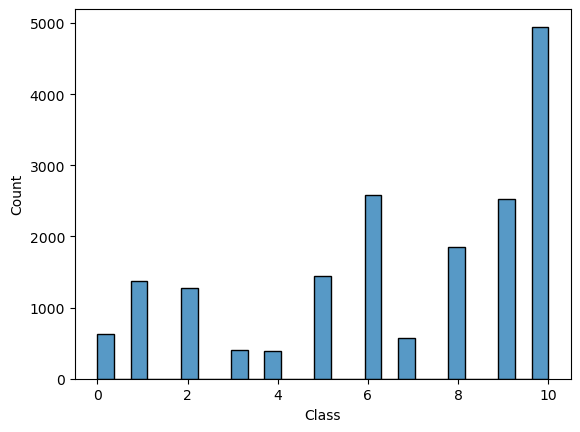

In [8]:
sns.histplot(data, x='Class');

We see that classes are heavily unbalanced

Lets check whether NaN is a feature and is special to some class. For this lets count sum of nulls for class and divide it by its size

In [9]:
def relative_is_null_sum(x):
    return x.isnull().sum() / x.shape[0]


data_is_null_agg = (
    data.groupby("Class")
    .agg(
        {
            "instrumentalness": relative_is_null_sum,
            "key": relative_is_null_sum,
            "Popularity": relative_is_null_sum,
        }
    )
    .reset_index()
)

data_is_null_agg

,Class,instrumentalness,key,Popularity
0,0,0.220800,0.110400,0.118400
1,1,0.127458,0.114348,0.021122
2,2,0.111635,0.145440,0.011792
3,3,0.241294,0.077114,0.034826
4,4,0.534884,0.108527,0.051680
5,5,0.600553,0.082239,0.015204
6,6,0.099343,0.111326,0.016622
7,7,0.001736,0.151042,0.050347
8,8,0.084682,0.086839,0.017260
9,9,0.499604,0.120048,0.024960


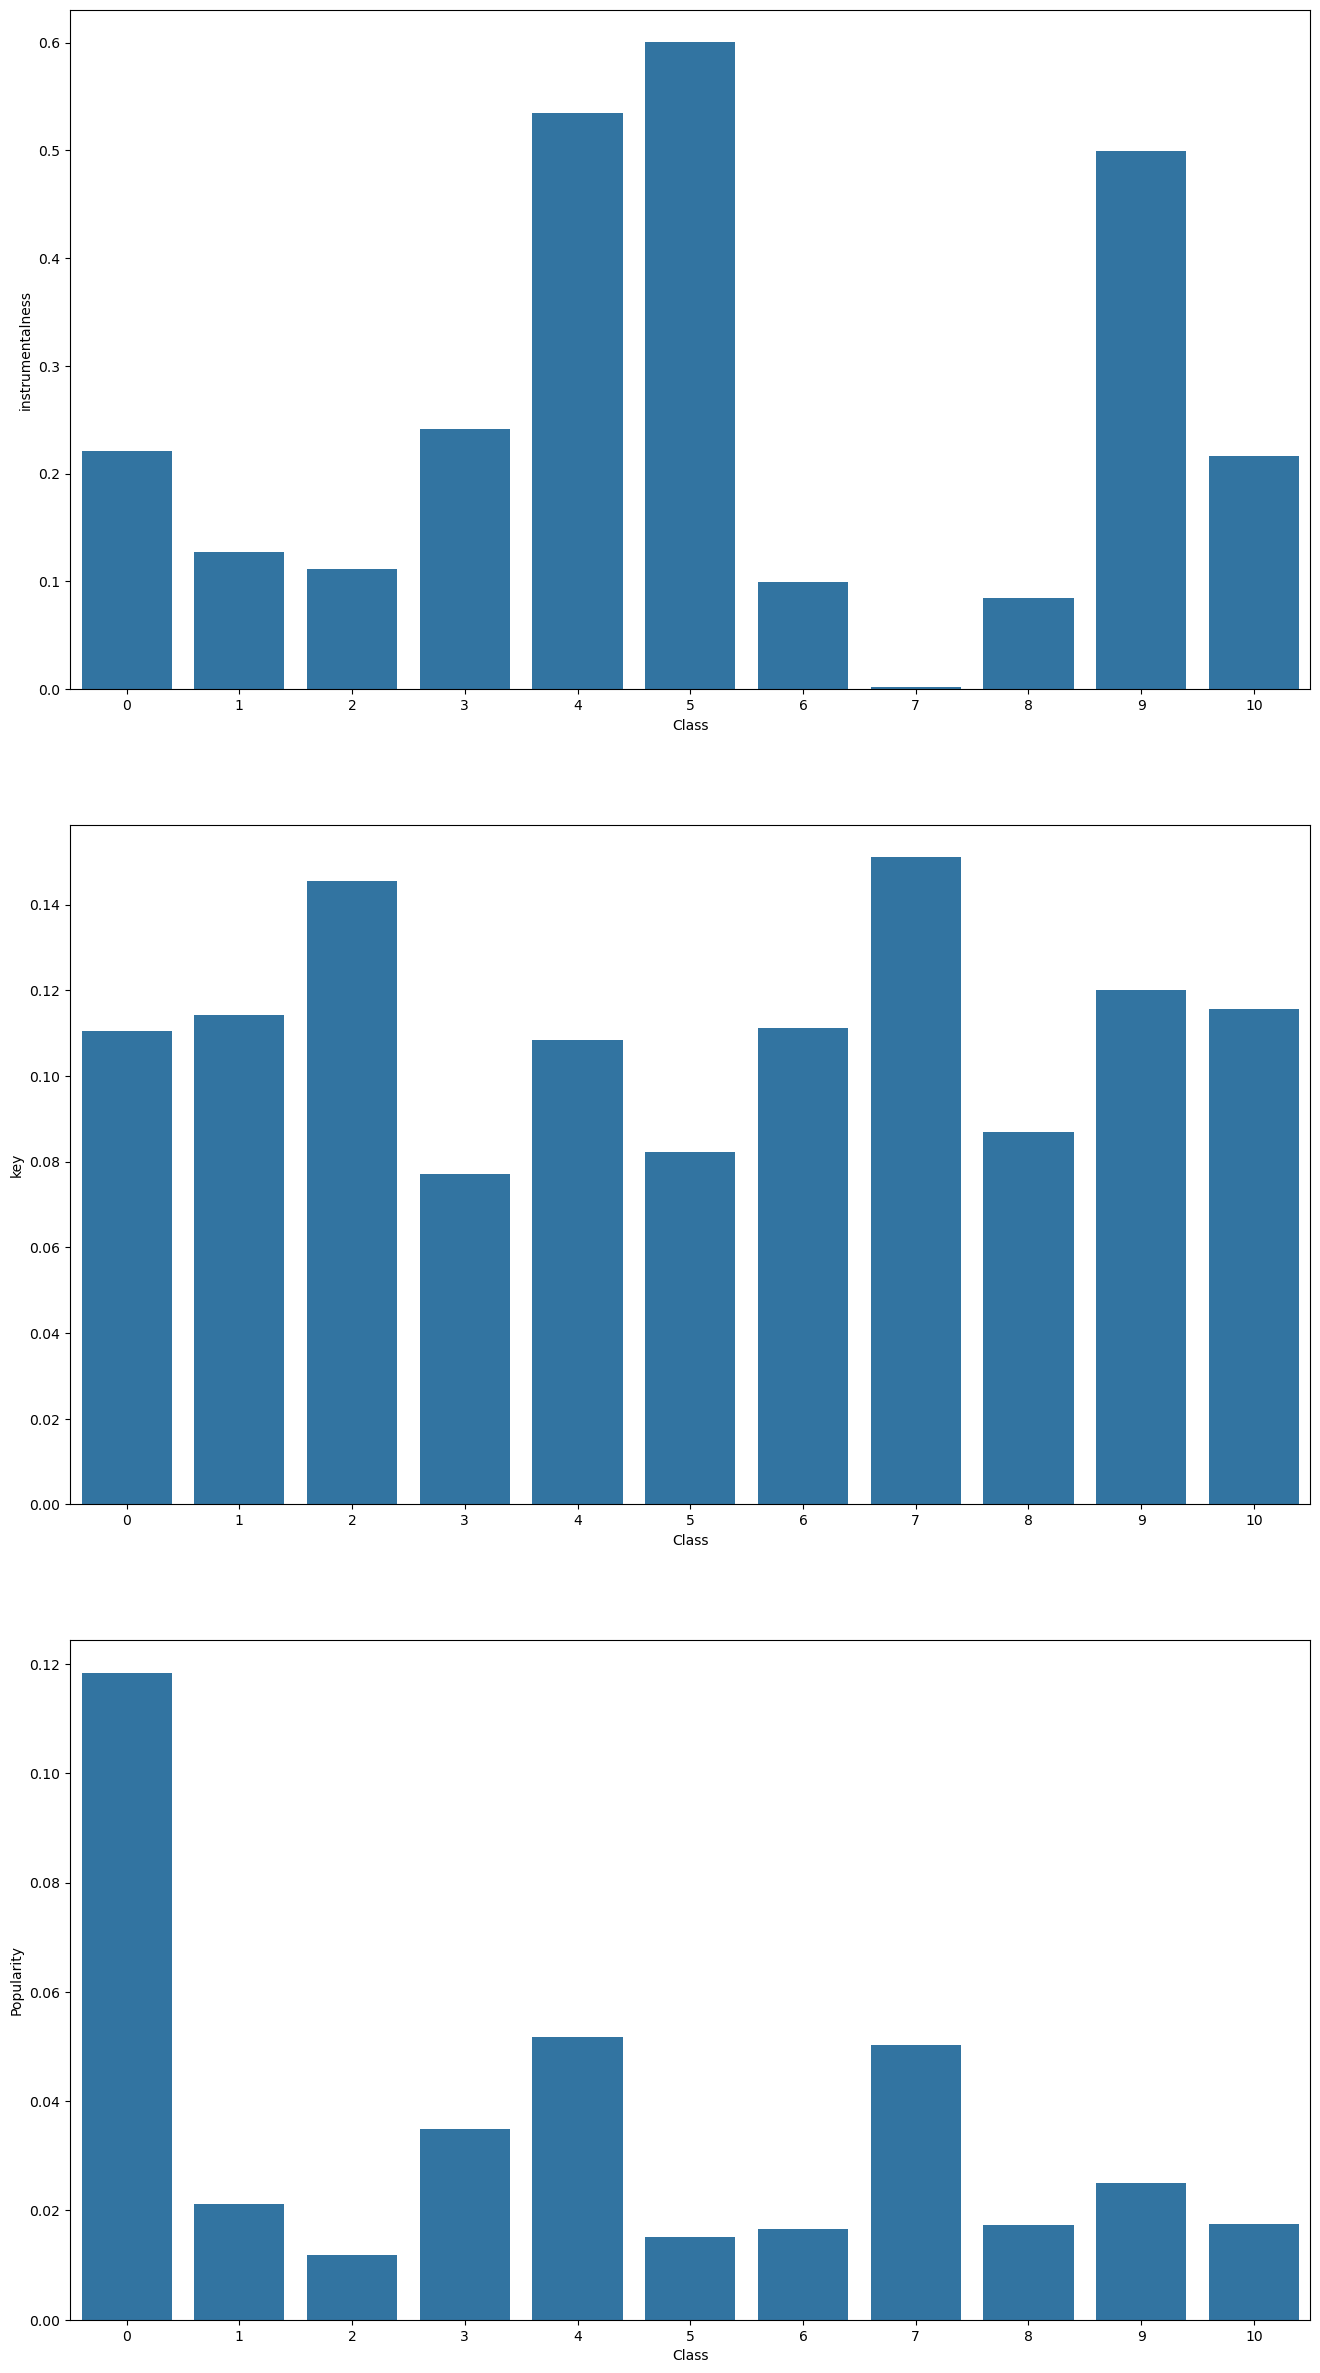

In [10]:
fig = plt.figure(figsize=(16, 30))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

sns.barplot(data_is_null_agg, x="Class", y="instrumentalness", ax=ax1)
sns.barplot(data_is_null_agg, x="Class", y="key", ax=ax2)
sns.barplot(data_is_null_agg, x="Class", y="Popularity", ax=ax3);

We see that although NaN are usually distributed quite equally along classes, for some it reaches 40-60% of data (instrumentalness). And this might be an actual feature of our data

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

So we will drop NAs for Popularity  and key column (and lose ~10% of data) and try to impute large number for instrumentalness

In [11]:
data.dropna(subset=["Popularity", "key"], inplace=True)

instrumentalness data is in range (0, 1) so let's imput large value, say, 100

In [12]:
data.fillna({'instrumentalness': 100}, inplace=True)

I am not quite sure what key is in music, but i suppose it is music tonality, hence we can keep it as numeric data

Also we need probably need to drop Artist Name and	Track Name потому что я так чувствую. It is highly unlikely that song name may be a good predictor for class. On the other hand artists tend to make music mainly in single genre and this can be good prediction. However we have about 9000 artists and i (yet) see no way how to transform it into feature for decision tree model

In [13]:
data.drop(["Artist Name", "Track Name"], axis=1, inplace=True)

Split data

In [14]:
X, y = data.loc[:, data.columns != "Class"], data["Class"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

Let's try unlomited DT

Let's try to wrap it up in pipeline

In [16]:
categorical_features = ["mode", "time_signature"]

We need to transfor categorical values

In [17]:
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(), categorical_features)],
    remainder="passthrough",
)

In [18]:
dt_model = DecisionTreeClassifier(random_state=SEED)

In [19]:
pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", dt_model)])

In [20]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['mode',
                                                   'time_signature'])])),
                ('classifier', DecisionTreeClassifier(random_state=123))])

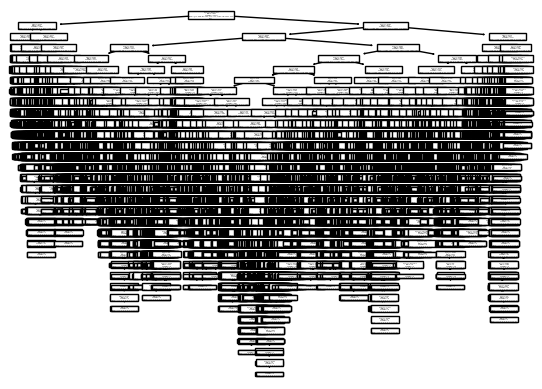

In [21]:
tree.plot_tree(pipeline["classifier"]);

💀💀💀

It' kinda obvious that this model is overfitted

StratifiedKFold is used here as it decreases bias from unbalanced classes in our data

In [22]:
skuf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

Accuracy is used here as a metric as:
- we are generally interested that model works OK
- it is easiest to calculate for multiclass

In [23]:
accuracies = []

for train_index, val_index in skuf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    pipeline.fit(X_train_fold, y_train_fold)
    y_val_pred = pipeline.predict(X_val_fold)

    fold_accuracy = accuracy_score(y_val_fold, y_val_pred)
    accuracies.append(fold_accuracy)

mean_accuracy = np.mean(accuracies)
print(f"Mean cross-validated accuracy: {mean_accuracy:.2f}")

Mean cross-validated accuracy: 0.37


Let's try to tune it with hyperparams using GridSearchCV

In [24]:
param_grid = {
    "classifier__max_depth": np.arange(3, 15),
}

In [25]:
grid_search = GridSearchCV(pipeline, param_grid, cv=skuf, scoring="accuracy")
grid_search.fit(X, y)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(),
                                                                         ['mode',
                                                                          'time_signature'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=123))]),
             param_grid={'classifier__max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
             scoring='accuracy')

In [26]:
best_params = grid_search.best_params_

In [27]:
best_params

{'classifier__max_depth': 8}

In [28]:
y_pred = grid_search.predict(X)
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy with best hyperparameters: {accuracy:.2f}")

Accuracy with best hyperparameters: 0.53


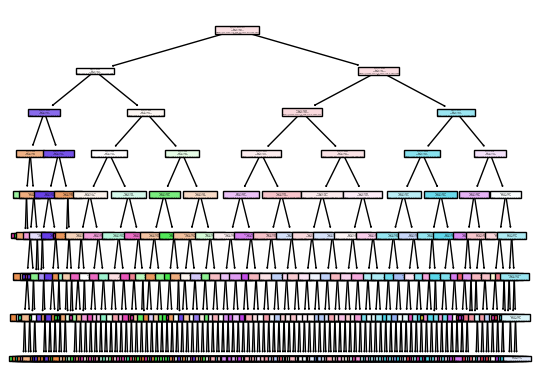

In [29]:
tree.plot_tree(grid_search.best_estimator_["classifier"], filled=True);

This tree seems to be still hard to interpret. On the other side, we have large number of classes. Lets try to tune other parameters in our model

In [30]:
ccp_alphas = grid_search.best_estimator_["classifier"].cost_complexity_pruning_path(
    X, y
)["ccp_alphas"][
    :-1
]  # from video https://www.youtube.com/watch?v=q90UDEgYqeI

In [31]:
ccp_alphas.shape

(184,)

In [32]:
param_grid = {
    "classifier__max_depth": np.arange(3, 15),
    #"classifier__criterion": ["gini", "entropy"],
    # "classifier__ccp_alpha": ccp_alphas, # takes too long
    "classifier__max_leaf_nodes": list(np.arange(20, 40)),
}

In [33]:
grid_search = GridSearchCV(pipeline, param_grid, cv=skuf, scoring="accuracy")
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(),
                                                                         ['mode',
                                                                          'time_signature'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=123))]),
             param_grid={'classifier__max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'classifier__max_leaf_nodes': [20, 21, 22, 23, 24, 25,
                                                        26, 27, 28, 29, 30, 31,
                                                        32, 33, 34, 35, 36, 37,
                                                        38, 39]},
             scoring='accuracy')

In [34]:
y_pred = grid_search.predict(X)
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy with best hyperparameters: {accuracy:.2f}")

Accuracy with best hyperparameters: 0.49


In [35]:
best_params = grid_search.best_params_
best_params

{'classifier__max_depth': 9, 'classifier__max_leaf_nodes': 39}

In [36]:
fig = plt.figure(figsize=(50, 20), dpi=300)
tree.plot_tree(
    grid_search.best_estimator_["classifier"], 
    filled=True,   
    fontsize=5
    );

What i tried here is to make decision tree more interpretable, sacrificing accuracy (0.04). However it is almost useless here, it might be actually useful when interpreting trees with smaller number of classes to be predicted

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. Мне очень нравится серия love, death + robots, первый сезон самый 🔥🔥🔥, а любимый эпизод оттуда The Witness, вообще у Альберто Мьельго крутой визуальный стиль очень

2. Раз уж речь случайно зашла про визуальный стиль, тут надо упомянуть Уэса Андерсона, настоящий стиль в мельчайших деталях, наверное мой любимый режиссер

3. Ещё мне нравятся старые фильмы Гая Ричи, а еще трилогия Крестного отца (все пересматривал по неск раз), но два самых любимых фильма, наверное, Лобстер и Одержимость (который Whiplash, его какое-то невменяемое количество раз пересматривал), а еще все фильмы Тарантино